In [47]:
from tools import *
from config import *

In [2]:
def order_class(predictor, pred):
    res = np.zeros(pred[~np.isnan(pred)].shape[0], dtype=int)
    cc = predictor.cluster_centers.reshape(-1)
    classes = np.arange(cc.shape[0])
    ind = np.lexsort([cc])
    cc = cc[ind]
    classes = classes[ind]
    for c in range(cc.shape[0]):
        mask = np.argwhere(pred == classes[c])
        res[mask] = c
    return res

def class_risk(ypred, ytrue, ybin, nameDep : str, predictor) -> dict:
    if torch.is_tensor(ypred):
        ypred = ypred.detach().cpu().numpy().astype(float)
    if torch.is_tensor(ytrue):
        ytrue = ytrue.detach().cpu().numpy().astype(float)

    res = {}

    yclass = predictor.predict(ytrue)
    yclass = order_class(predictor, yclass)
    uniqueClass = np.unique(yclass)
    res[nameDep] = {}
    for c in uniqueClass:
        classIndex = np.argwhere(yclass == c)
        classPred = ypred[classIndex]
        classTrue = ypred[classIndex]
        error = abs(classPred - classTrue)
        classBin = ybin[classIndex]
        meanF = round(np.mean(classBin), 3)
        print(c, np.nansum(classBin), np.nansum(ybin))
        meanFF = round(100 * (np.nansum(classBin) / np.nansum(ybin)))
        meanP = round(np.mean(classPred), 3)
        meanT = round(np.mean(classTrue), 3)
        error = round(np.mean(error))
        res[nameDep][c] = (round(predictor.get_centroid(c)[0], 3), meanP, meanT, error, meanFF, meanF)
        
    return res[nameDep]

def get_max(influence):
    return np.nanmax(influence)

def get_sum(influence):
    return np.nansum(influence)

In [3]:
allMonth = [date.split('-')[1] for date in allDates]


def analyse_target(scales, exps, nameExp, test):
    classs = {}
    f1s = {}
    means = {}
    means2 = {}
    for ni, scale in enumerate(scales):
        classs[scale] = {}
        p = Path(exps[ni] + '/' + nameExp+'/train/')
        print(p)
        Y = read_object('Y_full_'+scale+'.pkl', p)
        print(np.min(Y[:, -1]), np.max(Y[:, -1]))
        Y_month = [allMonth[int(di)] for di in Y[:,4]]
        graph = read_object('graph_'+scale+'.pkl', p)
        print(scale, Y[Y[:,-2] > 0].shape, Y[(Y[:,-3] > 0) & (Y[:,-2] > 0)].shape)
        print(np.unique(Y[:,4]).shape, (allDates.index('2023-01-01')))
        departements = ['departement-01-ain',
                        'departement-25-doubs',
                        'departement-78-yvelines',
                        'departement-69-rhone'
                        ]
        bins = []
        influences = []
        mean = []
        mean2 = []
        for dep in departements:
            classs[scale][dep] = {}
            dir_predictor = p / 'influenceClustering'
            predictor = read_object(dep+'Predictor'+scale+'.pkl', dir_predictor)
            bin = Y[Y[:,3] == name2int[dep]][:,-2]
            influence = Y[Y[:,3] == name2int[dep]][:,-1]

            bins += list(bin[~np.isnan(bin)])
            influences += list(influence[~np.isnan(bin)])
            print(influence[~np.isnan(bin)].shape)
            classs[scale][dep]['class'] = class_risk(influence[~np.isnan(bin)], influence[~np.isnan(bin)], bin[~np.isnan(bin)] > 0, dep, predictor)
            Y2 = np.empty((influence[~np.isnan(bin)].shape[0], 8))
            Y2[:, -2] = bin[~np.isnan(bin)]
            Y2[:, -1] = influence
            Y2[:, 3] = name2int[dep]
            classss = predictor.predict(influence[~np.isnan(bin)]).reshape(-1,1).astype(int)
            classs[scale][dep]['weighted_f1'] = my_f1_score(Y2, influence[~np.isnan(bin)], False, predictor.weight_array(classss).reshape(-1))
            classs[scale][dep]['non_weighted_f1'] = my_f1_score(Y2, influence[~np.isnan(bin)], False, None)
            if len(mean) == 0:
                for c in [0,1,2,3,4]:
                    mean.append(classs[scale][dep]['class'][c][-1])
                    mean2.append(classs[scale][dep]['class'][c][-2])
                f1s['weighted_f1'] = classs[scale][dep]['weighted_f1'][0]
                f1s['non_weighted_f1'] = classs[scale][dep]['non_weighted_f1'][0]
            else:
                for c in [0,1,2,3,4]:
                    mean[c] += classs[scale][dep]['class'][c][-1]
                    mean2[c] += classs[scale][dep]['class'][c][-2]
                f1s['weighted_f1'] += classs[scale][dep]['weighted_f1'][0]
                f1s['non_weighted_f1'] += classs[scale][dep]['non_weighted_f1'][0]

        mean = np.asarray(mean) / len(departements)
        mean2 = np.asarray(mean2) / len(departements)
        f1s['weighted_f1'] = f1s['weighted_f1']  / len(departements)
        f1s['non_weighted_f1'] = f1s['non_weighted_f1']  / len(departements)

        means[scale] = mean
        means2[scale] = mean2

    return classs, f1s, means, means2

scales = ['10']
exps = ['final']
nameExp = 'firepoint/2x2/'
test = "2023"
classs, f1s, means, means2 = analyse_target(scales, exps, nameExp, test)

final/firepoint/2x2/train
1.4491524993887062e-10 43.61857362475375
10 (7191, 9) (7191, 9)
(2573,) 2029
(52162,)
0 0 2516
1 288 2516
2 1305 2516
3 716 2516
4 207 2516
(51460,)
0 0 1890
1 1086 1890
2 542 1890
3 214 1890
4 48 1890
(23157,)
0 0 1983
1 827 1983
2 651 1983
3 384 1983
4 121 1983
(15153,)
0 0 802
1 206 802
2 438 802
3 139 802
4 19 802


In [21]:
classs

{'10': {'departement-01-ain': {'class': {0: (0.077, 0.044, 0.044, 0, 0, 0.0),
    1: (6.347, 1.743, 1.743, 0, 11, 0.039),
    2: (1.744, 3.588, 3.588, 0, 52, 0.369),
    3: (11.264, 6.343, 6.343, 0, 28, 0.529),
    4: (3.594, 11.209, 11.209, 0, 8, 0.699)},
   'weighted_f1': (0.7755934415531447,
    0.6394512072096308,
    0.9853870867447404,
    0.9,
    17.508282544128498),
   'non_weighted_f1': (0.4870862827625789,
    0.46956842493544815,
    0.5059618441971383,
    0.9,
    17.508282544128498)},
  'departement-25-doubs': {'class': {0: (0.072, 0.033, 0.033, 0, 0, 0.0),
    1: (11.084, 2.285, 2.285, 0, 57, 0.234),
    2: (2.314, 5.294, 5.294, 0, 29, 0.519),
    3: (22.097, 11.114, 11.114, 0, 11, 0.767),
    4: (5.31, 21.987, 21.987, 0, 3, 0.873)},
   'weighted_f1': (0.6379703534777651,
    0.8528963414634146,
    0.5095628415300546,
    0.9,
    33.99032057266008),
   'non_weighted_f1': (0.49542961608775143,
    0.584051724137931,
    0.4301587301587302,
    0.9,
    33.9903205726600

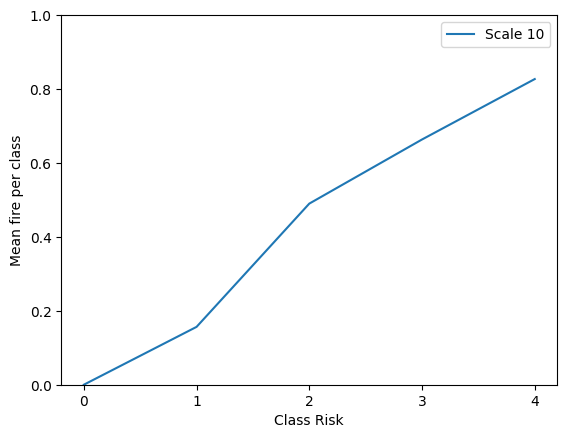

In [22]:
for sc in scales:
    plt.plot(np.arange(5), means[sc],label='Scale ' + sc)

plt.xticks([0,1,2,3,4])
plt.ylim(0, 1)
plt.ylabel('Mean fire per class')
plt.xlabel('Class Risk')
plt.legend()

In [17]:
means[sc]

array([0.    , 0.1565, 0.49  , 0.6635, 0.827 ])

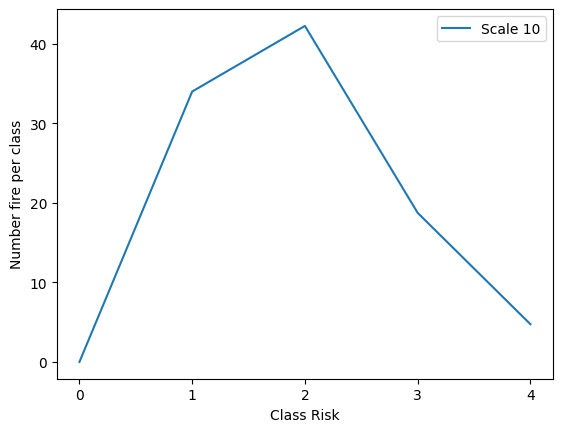

In [16]:
for sc in scales:
    plt.plot(np.arange(5), means2[sc],label='Scale ' + sc)

plt.xticks([0,1,2,3,4])
plt.ylabel('Number fire per class')
plt.xlabel('Class Risk')
plt.legend()

(141932, 403) (141932, 9)
8301.0


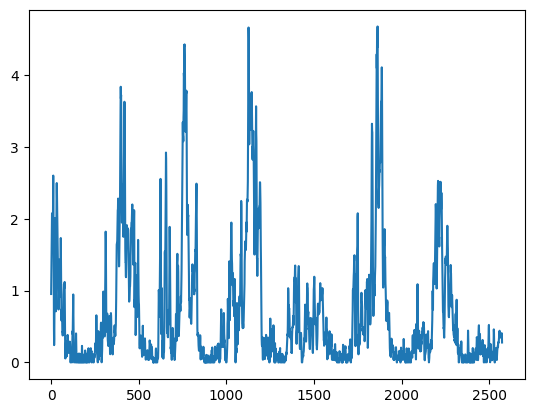

In [49]:
name_exp = 'final'
sinister = 'firepoint'

Y = read_object('Y_full_10.pkl', Path(name_exp + '/' + sinister + '/' +'2x2' + '/' + 'train'))
X = read_object('X_full_10.pkl', Path(name_exp + '/' + sinister + '/' +'2x2' + '/' + 'train'))
graph = read_object('graph_10.pkl', Path(name_exp + '/' + sinister + '/' + '2x2/train'))
print(X.shape, Y.shape)
pos_feature, _ = create_pos_feature(10, 6, features)
Y_by_date = []
udates = np.unique(Y[:,4])
for d in udates:
    Y_by_date.append(np.mean(Y[Y[:,4] == d][:, -1]))
    
Y_by_date = np.asarray(Y_by_date)
plt.plot(Y_by_date)
print(np.sum(Y[:, -2]))

In [ ]:
pred1 = read_object('xgboost_nbsinister_full_0_10_100_10_z-score_Catboost_departement-78-yvelines_pred.pkl',
                    Path(name_exp + '/' + sinister + '/' +'2x2' + '/' + 'test/departement-78-yvelines/full_0_10_100/xgboost_nbsinister'))
pred2 = read_object('xgboost_risk_full_0_10_100_10_z-score_Catboost_departement-78-yvelines_pred.pkl',
                    Path(name_exp + '/' + sinister + '/' +'2x2' + '/' + 'test/departement-78-yvelines/full_0_10_100/xgboost_risk'))

In [46]:
pred1.shape

(3591, 13)

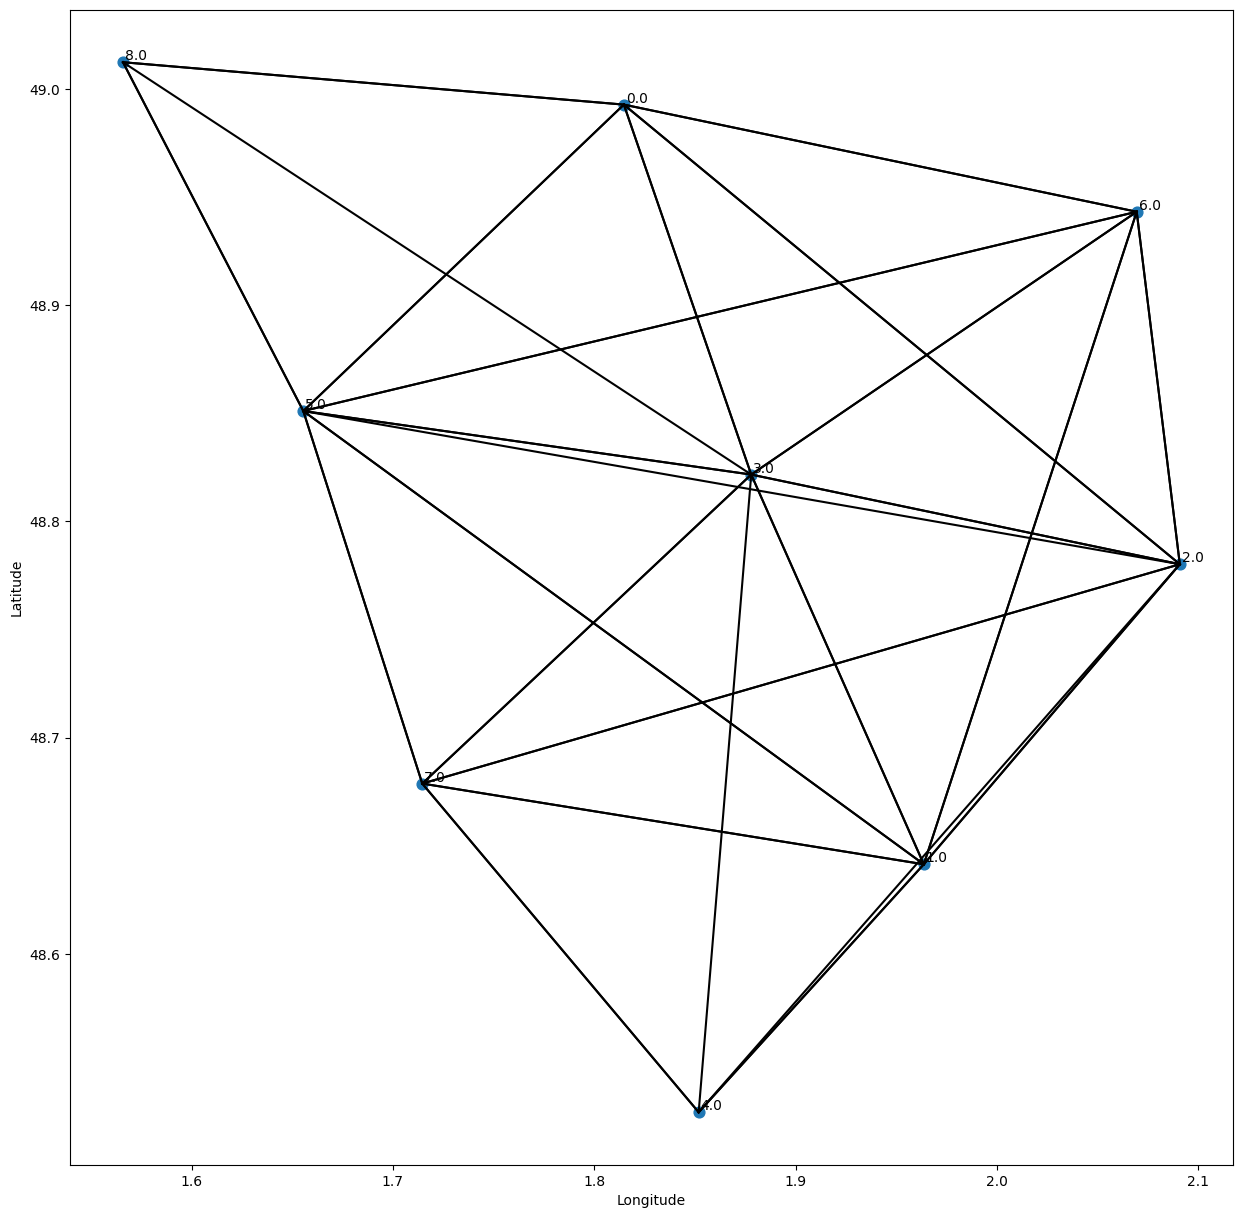

In [29]:
graph._plot(graph.nodes[graph.nodes[:, 3] == 78])

In [39]:
np.argwhere(X == np.nanmax(X))

array([[2996,   60]])

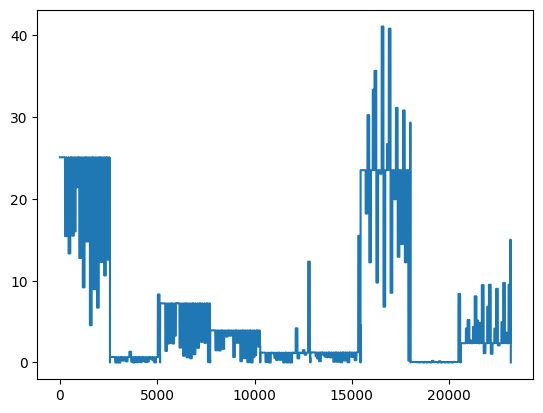

In [43]:
plt.plot(X[:, 360])

In [30]:
X[:, 0]

array([0., 0., 0., ..., 8., 8., 8.])

In [51]:
x50 = X[X[:, 0] == 8]
y50 = Y[Y[:, 0] == 17]
x47 = X[X[:, 0] == 0]

In [7]:
x50[:, 1], y50[:, 1]

(array([5.62185654, 5.62185654, 5.62185654, ..., 5.62185654, 5.62185654,
        5.62185654]),
 array([5.62185654, 5.62185654, 5.62185654, ..., 5.62185654, 5.62185654,
        5.62185654]))

In [36]:
pos_feature['Calendar'] + (calendar_variables.index('dayofweek'))

368

In [15]:
X[:, pos_feature['dynamicWorld'] + (3 * 4) + 1].min()

0.0

In [10]:
x50

array([], shape=(0, 403), dtype=float64)

In [53]:
np.unique(x50[:, 366])

array([ 0.45487033,  0.51257905,  0.74163637,  1.87137873,  1.93781528,
        2.04838418,  2.79741432,  4.41099934,  4.61160282,  5.03517491,
        6.90820623, 10.18624031])

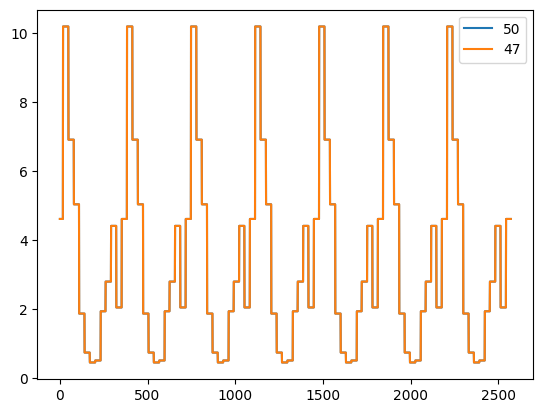

In [52]:
plt.plot(x50[:, 366], label='50')
plt.plot(x47[:, 366], label='47')
plt.legend()

In [57]:
np.unique(X[:, pos_feature['Geo']])

array([2.70325304, 3.49902871, 3.56373677, 4.48892857])

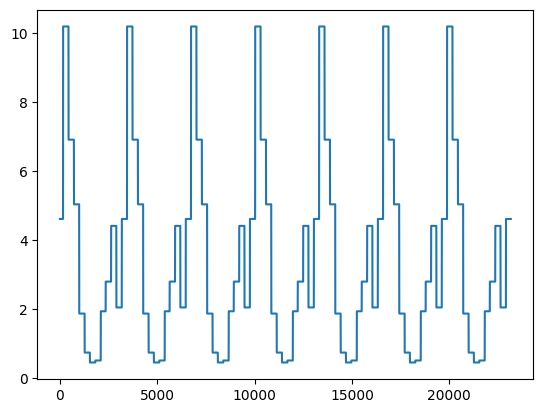

In [55]:
X2 = X[X[:, 3] == 78]
ind = np.lexsort([X2[:, 4]])
X2 = X2[ind]
plt.plot(X2[:, pos_feature['Calendar'] + calendar_variables.index('month')])

In [52]:
allDates[1493]

'2021-07-14'

In [47]:
maxi = X2[:, pos_feature['Calendar'] + calendar_variables.index('dayofyear')].max()
X2[X2[:, pos_feature['Calendar'] + calendar_variables.index('dayofyear')] == maxi][:, 4]

array([  32.,  397.,  762., 1128., 1493., 1858., 2223.])

In [36]:
X[X[:, 3] == 1, 288].max()

17.550297

In [32]:
ain = X[X[:, 3] == 1]
ain[ain[:, 272] == np.max(ain[:, 272])][:, 0]

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2.])

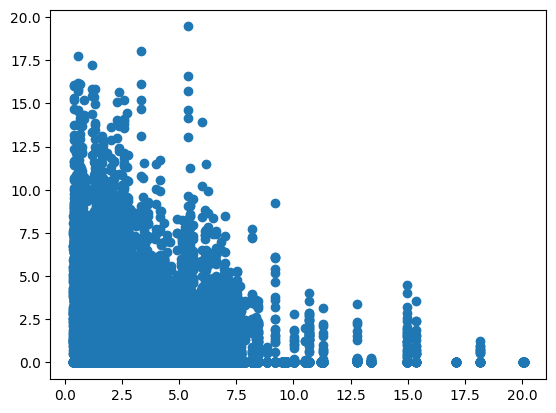

In [41]:
plt.scatter(X[X[:, 3] == 1, 266], Y[X[:, 3] == 1, -1])

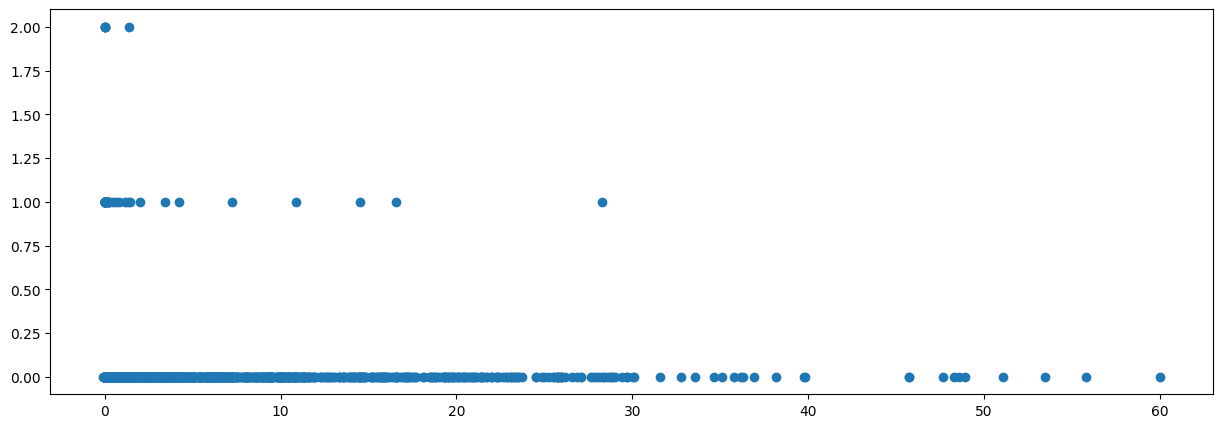

In [41]:
plt.figure(figsize=(15,5))
plt.scatter(x50[:, pos_feature['prec24h']], y50[:, -2])

In [51]:
firepointcsv = pd.read_csv('/home/caron/Bureau/csv/departement-01-ain/firepoint/NATURELSfire.csv')

In [55]:
firepointcsv[firepointcsv['date'] == '2018-04-12']

,id_intervention,raison_sortie,date_debut,date_fin,FL_CCR_CCF,nb_eng_CC,label,year,geometry,latitude,longitude,IN,date,type,coef,h3
66,18BB016480,NATURELS,2018-04-12 16:52:38,2018-04-12 17:15:01,1.0,1.0,1.0,2018,POINT (5.693479892334558 45.71028415571681),45.710284,5.693480,True,2018-04-12,NATURELS,1.0,871f9171effffff
67,18BB016500,NATURELS,2018-04-12 19:11:22,2018-04-12 21:59:45,1.0,3.0,1.0,2018,POINT (5.809188142285021 46.08798626074307),46.087986,5.809188,True,2018-04-12,NATURELS,1.0,871f91075ffffff
68,18BB016516,NATURELS,2018-04-12 20:39:51,2018-04-12 21:20:52,1.0,1.0,1.0,2018,POINT (5.655320778801857 46.257765120417965),46.257765,5.655321,True,2018-04-12,NATURELS,1.0,871f918ceffffff


In [59]:
firepointcsv['id'] = graph._predict_node(list(zip(firepointcsv.longitude, firepointcsv.latitude)))
firepointcsv[firepointcsv['date'] == '2018-04-12'].id

66    50
67    56
68    26
Name: id, dtype: int32

In [56]:
fire = y50[y50[:, -2] > 0]
dates = [allDates[int(f)] for f in np.unique(fire[:, 4])]

for d in dates:
    if d not in firepointcsv.date.unique():
        print(d)

In [6]:
pos_feature

{'temp': 6,
 'dwpt': 10,
 'rhum': 14,
 'prcp': 18,
 'wdir': 22,
 'wspd': 26,
 'prec24h': 30,
 'dc': 34,
 'ffmc': 38,
 'dmc': 42,
 'nesterov': 46,
 'munger': 50,
 'kbdi': 54,
 'isi': 58,
 'angstroem': 62,
 'bui': 66,
 'fwi': 70,
 'dailySeverityRating': 74,
 'temp16': 78,
 'dwpt16': 82,
 'rhum16': 86,
 'prcp16': 90,
 'wdir16': 94,
 'wspd16': 98,
 'prec24h16': 102,
 'days_since_rain': 106,
 'sum_consecutive_rainfall': 110,
 'sum_last_7_days': 114,
 'elevation': 118,
 'population': 122,
 'sentinel': 126,
 'landcover': 146,
 'vigicrues': 154,
 'foret': 158,
 'highway': 234,
 'dynamicWorld': 258,
 'Calendar': 294,
 'Historical': 309,
 'Geo': 313,
 'air': 314,
 'nappes': 318,
 'AutoRegressionReg': 326,
 'AutoRegressionBin': 327}

In [120]:
X[:, pos_feature['vigicrues']: pos_feature['vigicrues'] + 4] = -1

In [140]:
np.unique(X[:, :127], axis=0).shape, np.unique(Y, axis=0).shape

((8164, 127), (8162, 9))

In [100]:
X.shape

(10211, 328)

In [40]:
iuds = np.unique(Y[:, 0])
for iud in iuds:
    zerosiud = Y[Y[:, 0] == iud]
    if zerosiud.shape != np.unique(zerosiud, axis=0).shape:
        print(iud, zerosiud.shape, np.unique(zerosiud, axis=0).shape)

0.0 (332, 9) (243, 9)
2.0 (399, 9) (318, 9)
3.0 (224, 9) (173, 9)
5.0 (401, 9) (319, 9)
6.0 (327, 9) (258, 9)
8.0 (397, 9) (339, 9)
9.0 (417, 9) (326, 9)
10.0 (155, 9) (145, 9)
11.0 (406, 9) (331, 9)
12.0 (163, 9) (138, 9)
13.0 (376, 9) (317, 9)
15.0 (256, 9) (190, 9)
16.0 (362, 9) (266, 9)
17.0 (411, 9) (328, 9)
18.0 (406, 9) (333, 9)
20.0 (443, 9) (355, 9)
23.0 (350, 9) (253, 9)
24.0 (280, 9) (216, 9)
25.0 (401, 9) (314, 9)
26.0 (317, 9) (240, 9)
28.0 (400, 9) (327, 9)
29.0 (384, 9) (311, 9)
30.0 (455, 9) (371, 9)
31.0 (385, 9) (315, 9)
32.0 (317, 9) (238, 9)
33.0 (429, 9) (335, 9)
34.0 (211, 9) (172, 9)
36.0 (412, 9) (339, 9)
38.0 (395, 9) (327, 9)


In [39]:
iuds = np.unique(X[:, 0])
for iud in iuds:
    zerosiud = X[X[:, 0] == iud]
    if zerosiud.shape != np.unique(zerosiud, axis=0).shape:
        print(iud, zerosiud.shape, np.unique(zerosiud, axis=0).shape)

0.0 (332, 328) (243, 328)
2.0 (399, 328) (343, 328)
3.0 (224, 328) (173, 328)
5.0 (401, 328) (340, 328)
6.0 (327, 328) (258, 328)
8.0 (397, 328) (349, 328)
9.0 (417, 328) (326, 328)
10.0 (155, 328) (145, 328)
11.0 (406, 328) (346, 328)
12.0 (163, 328) (138, 328)
13.0 (376, 328) (329, 328)
15.0 (256, 328) (190, 328)
16.0 (362, 328) (266, 328)
17.0 (411, 328) (328, 328)
18.0 (406, 328) (350, 328)
20.0 (443, 328) (384, 328)
23.0 (350, 328) (253, 328)
24.0 (280, 328) (216, 328)
25.0 (401, 328) (340, 328)
26.0 (317, 328) (240, 328)
28.0 (400, 328) (327, 328)
29.0 (384, 328) (328, 328)
30.0 (455, 328) (393, 328)
31.0 (385, 328) (337, 328)
32.0 (317, 328) (238, 328)
33.0 (429, 328) (363, 328)
34.0 (211, 328) (172, 328)
36.0 (412, 328) (353, 328)
38.0 (395, 328) (342, 328)


In [67]:
twoID = np.argwhere(X[:, 0] == 2)[:, 0]

X2 = X[twoID]
Y2 = Y[twoID]

X2.shape, Y2.shape 

((2371, 328), (2371, 9))

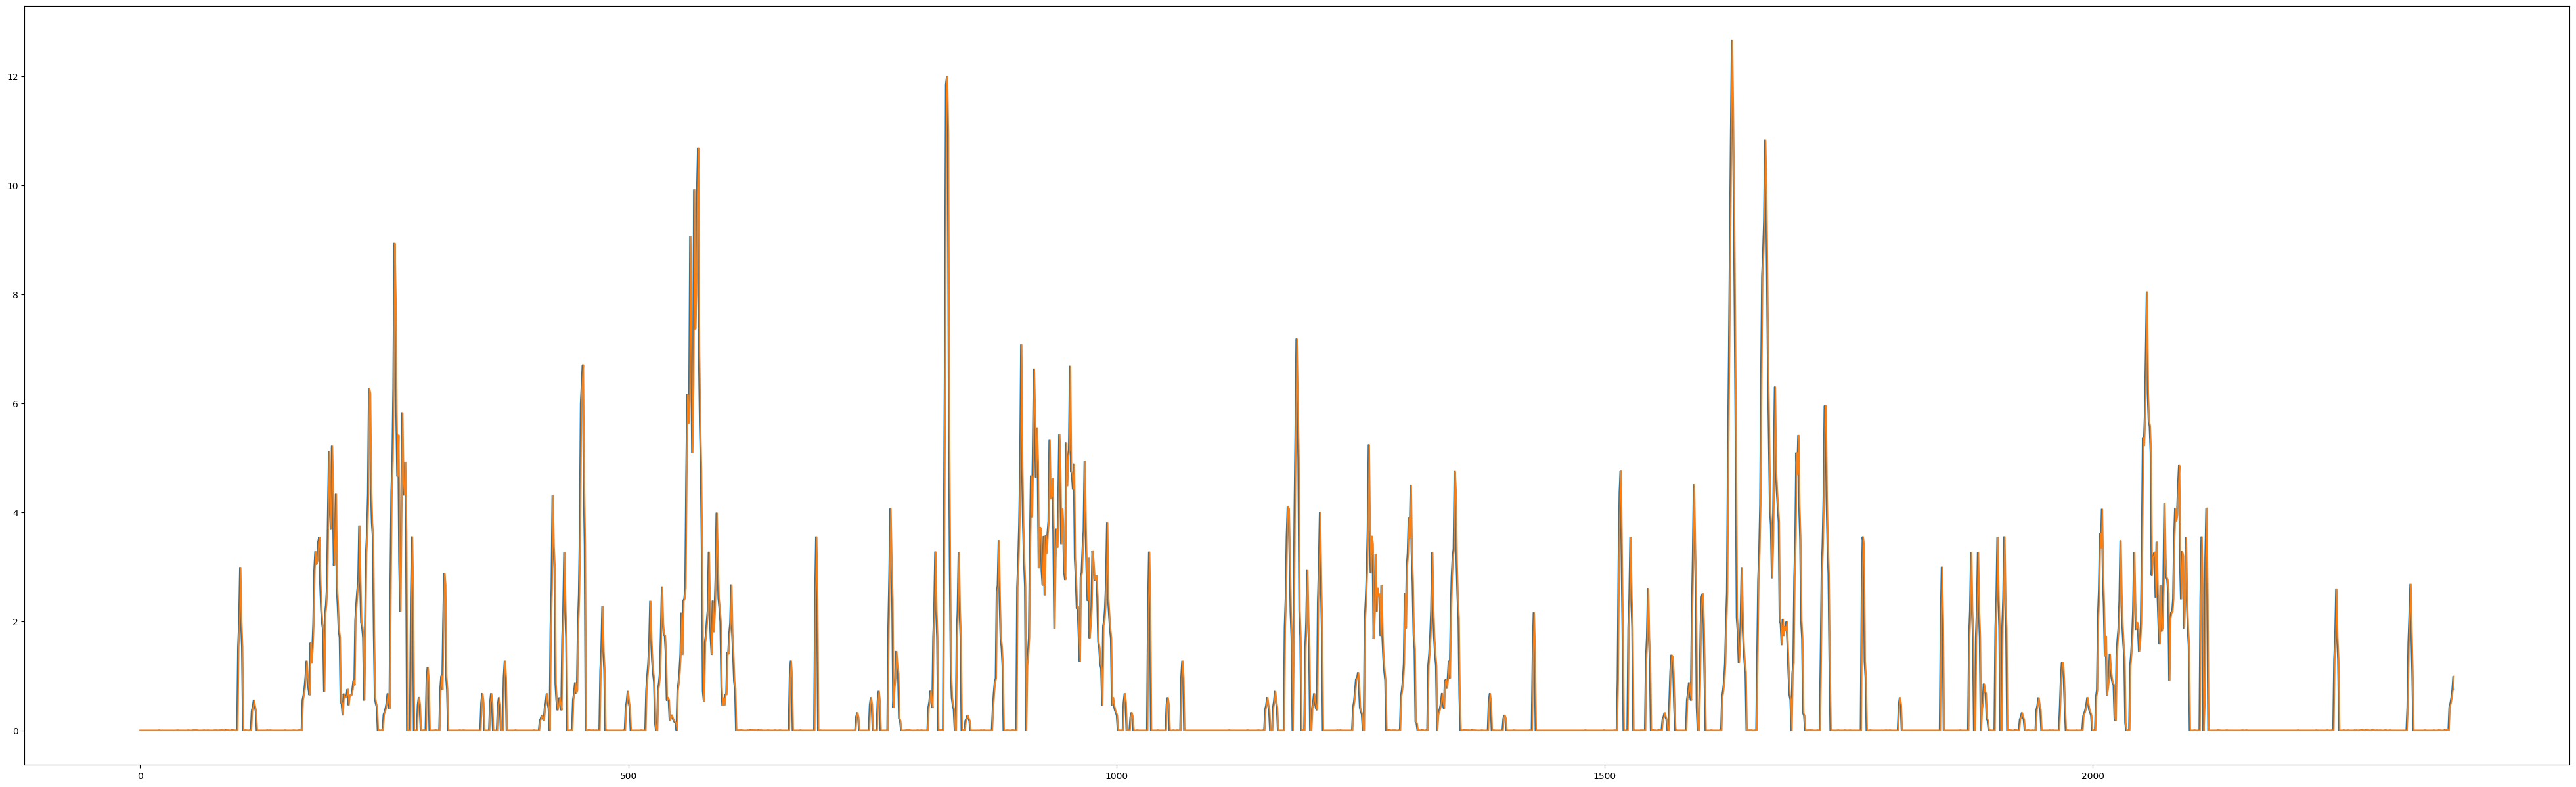

In [90]:
plt.figure(figsize=(50,15))
#plt.plot(np.unique(Y2, axis=0)[:, -2])
plt.plot(Y2[:, -1])
plt.plot(X2[:, -2])

In [77]:
np.unique(X2[:, -1] == Y2[:, -2])

array([False,  True])

In [62]:
np.sum(Y[:, -2]), np.sum([np.unique(Y2, axis=0)[:, -2]]), np.sum(X[:, -1])

(819.0, 21.0, 797.0)

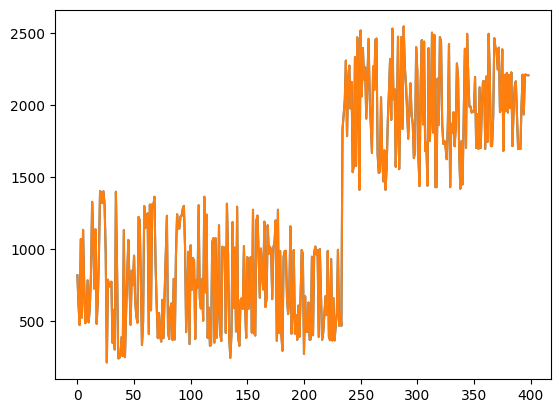

In [48]:
plt.plot(X2[:, 4])
plt.plot(Y2[:, 4])

In [17]:
pos_feature

{'temp': 6,
 'dwpt': 10,
 'rhum': 14,
 'prcp': 18,
 'wdir': 22,
 'wspd': 26,
 'prec24h': 30,
 'dc': 34,
 'ffmc': 38,
 'dmc': 42,
 'nesterov': 46,
 'munger': 50,
 'kbdi': 54,
 'isi': 58,
 'angstroem': 62,
 'bui': 66,
 'fwi': 70,
 'dailySeverityRating': 74,
 'temp16': 78,
 'dwpt16': 82,
 'rhum16': 86,
 'prcp16': 90,
 'wdir16': 94,
 'wspd16': 98,
 'prec24h16': 102,
 'days_since_rain': 106,
 'sum_consecutive_rainfall': 110,
 'sum_last_7_days': 114,
 'elevation': 118,
 'population': 122,
 'sentinel': 126,
 'landcover': 146,
 'vigicrues': 154,
 'foret': 158,
 'highway': 234,
 'dynamicWorld': 258,
 'Calendar': 294,
 'Historical': 309,
 'Geo': 313,
 'air': 314,
 'nappes': 318,
 'AutoRegressionReg': 326,
 'AutoRegressionBin': 327}

In [ ]:
np.unique()

In [30]:
np.round(np.unique(X[:, pos_feature['highway'] + 0]))

array([92., 92., 93., 93., 93., 94., 95., 95., 95., 95., 95., 95., 95.,
       96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96.,
       96., 96., 96., 97., 97., 97., 97., 97., 97., 97., 97., 97., 97.,
       97., 97., 97., 97., 97., 97., 97., 97., 97., 97., 98., 98., 98.,
       98., 98., 98., 98., 98., 98., 98.])

In [1]:
plt.figure(figsize=(15,5))
plt.plot(Y[:, -3])
#plt.plot(Y[:, -1])
print(np.sum(Y[:, -2]))
print(np.sum(Y[Y[:, 3] == 78][:, -3]))

NameError: name 'plt' is not defined

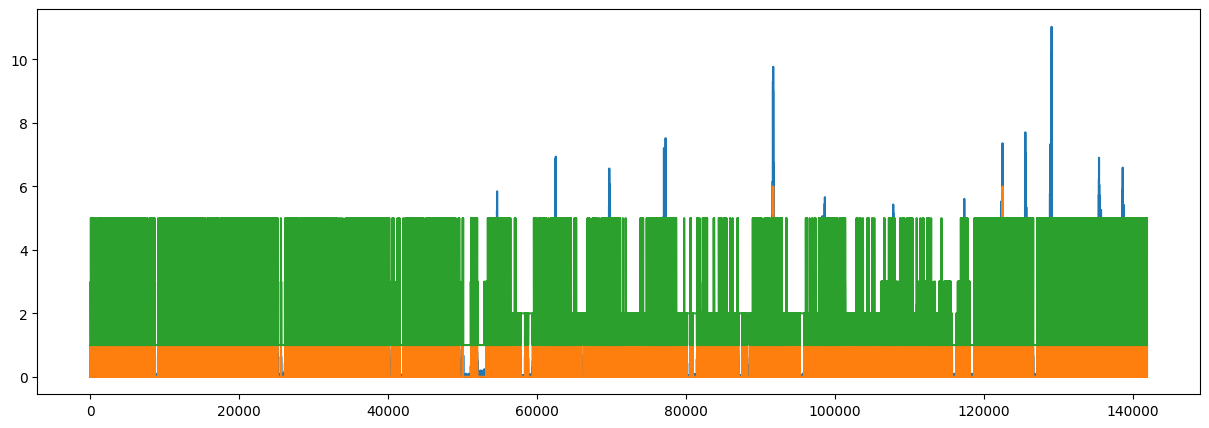

In [49]:
plt.figure(figsize=(15,5))
plt.plot(Y[:, -1])
plt.plot(Y[:, -2])
plt.plot(Y[:, -4])